# Home Credit Default Risk - LightGBM Pipeline

This notebook implements a complete machine learning pipeline for the Home Credit Default Risk competition.

## Pipeline Stages
1. **Data Loading** - Load 7 CSV tables
2. **Preprocessing** - Encoding, outlier handling, missing value marking
3. **Feature Engineering** - Derived features, aggregations, multi-table joins
4. **Model Training** - K-Fold cross-validation with LightGBM
5. **Output** - Predictions, feature importance, ROC curves, and training curves

In [1]:
# =============================================================================
# Stage 1: Data Loading
# =============================================================================
# Load all required libraries and read CSV files from disk

import numpy as np
import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuration
DEBUG = False  # Full training mode
NUM_ROWS = 10000 if DEBUG else None
DATA_PATH = './home-credit-default-risk/'  # Local data directory
SUBMISSION_FILE = 'submission_kernel02.csv'

@contextmanager
def timer(title):
    """Context manager for timing code blocks."""
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}s")

def sanitize_column_names(df):
    """Remove special characters from column names for LightGBM compatibility."""
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

# Load all datasets
with timer("Loading all datasets"):
    application_train = pd.read_csv(f'{DATA_PATH}application_train.csv', nrows=NUM_ROWS)
    application_test = pd.read_csv(f'{DATA_PATH}application_test.csv', nrows=NUM_ROWS)
    bureau = pd.read_csv(f'{DATA_PATH}bureau.csv', nrows=NUM_ROWS)
    bureau_balance = pd.read_csv(f'{DATA_PATH}bureau_balance.csv', nrows=NUM_ROWS)
    previous_application = pd.read_csv(f'{DATA_PATH}previous_application.csv', nrows=NUM_ROWS)
    pos_cash_balance = pd.read_csv(f'{DATA_PATH}POS_CASH_balance.csv', nrows=NUM_ROWS)
    installments_payments = pd.read_csv(f'{DATA_PATH}installments_payments.csv', nrows=NUM_ROWS)
    credit_card_balance = pd.read_csv(f'{DATA_PATH}credit_card_balance.csv', nrows=NUM_ROWS)

print(f"Train samples: {len(application_train)}, Test samples: {len(application_test)}")
print(f"Bureau records: {len(bureau)}, Bureau balance records: {len(bureau_balance)}")
print(f"Previous applications: {len(previous_application)}")
print(f"POS cash balance: {len(pos_cash_balance)}")
print(f"Installments payments: {len(installments_payments)}")
print(f"Credit card balance: {len(credit_card_balance)}")

Loading all datasets - done in 16s
Train samples: 307511, Test samples: 48744
Bureau records: 1716428, Bureau balance records: 27299925
Previous applications: 1670214
POS cash balance: 10001358
Installments payments: 13605401
Credit card balance: 3840312


In [2]:
# =============================================================================
# Stage 2: Data Preprocessing
# =============================================================================
# Handle encoding, outliers, and missing values

def one_hot_encoder(df, nan_as_category=True):
    """One-hot encoding for categorical columns with get_dummies."""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

with timer("Preprocessing application data"):
    df = pd.concat([application_train, application_test], ignore_index=True)
    df = df[df['CODE_GENDER'] != 'XNA']
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category=False)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

with timer("Preprocessing bureau and bureau_balance"):
    bureau_balance, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=True)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)

with timer("Preprocessing previous applications"):
    previous_application, prev_cat = one_hot_encoder(previous_application, nan_as_category=True)
    for col in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
                'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
        if col in previous_application.columns:
            previous_application[col].replace(365243, np.nan, inplace=True)

with timer("Preprocessing other tables"):
    pos_cash_balance, pos_cat = one_hot_encoder(pos_cash_balance, nan_as_category=True)
    installments_payments, ins_cat = one_hot_encoder(installments_payments, nan_as_category=True)
    credit_card_balance, cc_cat = one_hot_encoder(credit_card_balance, nan_as_category=True)

del application_train, application_test
gc.collect()
print(f"Preprocessed main df shape: {df.shape}")

Preprocessing application data - done in 1s


Preprocessing bureau and bureau_balance - done in 1s


Preprocessing previous applications - done in 1s


Preprocessing other tables - done in 2s
Preprocessed main df shape: (356251, 242)


In [3]:
# =============================================================================
# Stage 3: Feature Engineering
# =============================================================================

with timer("Creating application features"):
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

with timer("Creating bureau features"):
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        if col in bureau_balance.columns:
            bb_aggregations[col] = ['mean']
    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bureau_balance, bb_agg
    gc.collect()
    
    num_aggregations = {}
    agg_mapping = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    for col, aggs in agg_mapping.items():
        if col in bureau.columns:
            num_aggregations[col] = aggs
    cat_aggregations = {}
    for cat in bureau_cat:
        if cat in bureau.columns:
            cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        col_name = cat + "_MEAN"
        if col_name in bureau.columns:
            cat_aggregations[col_name] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    if 'CREDIT_ACTIVE_Active' in bureau.columns:
        active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
        if len(active) > 0:
            active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
            active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
            bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
            del active_agg
        del active
    if 'CREDIT_ACTIVE_Closed' in bureau.columns:
        closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
        if len(closed) > 0:
            closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
            closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
            bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
            del closed_agg
        del closed
    del bureau
    gc.collect()
    df = df.join(bureau_agg, how='left', on='SK_ID_CURR')
    del bureau_agg
    gc.collect()
    print(f"After bureau features: {df.shape}")

with timer("Creating previous application features"):
    previous_application['APP_CREDIT_PERC'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
    prev_num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'], 'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'], 'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'], 'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'], 'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'], 'CNT_PAYMENT': ['mean', 'sum'],
    }
    prev_num_aggregations = {k: v for k, v in prev_num_aggregations.items() if k in previous_application.columns}
    cat_aggregations = {cat: ['mean'] for cat in prev_cat if cat in previous_application.columns}
    prev_agg = previous_application.groupby('SK_ID_CURR').agg({**prev_num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    if 'NAME_CONTRACT_STATUS_Approved' in previous_application.columns:
        approved = previous_application[previous_application['NAME_CONTRACT_STATUS_Approved'] == 1]
        if len(approved) > 0:
            approved_agg = approved.groupby('SK_ID_CURR').agg(prev_num_aggregations)
            approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
            prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
            del approved_agg
        del approved
    if 'NAME_CONTRACT_STATUS_Refused' in previous_application.columns:
        refused = previous_application[previous_application['NAME_CONTRACT_STATUS_Refused'] == 1]
        if len(refused) > 0:
            refused_agg = refused.groupby('SK_ID_CURR').agg(prev_num_aggregations)
            refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
            prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
            del refused_agg
        del refused
    del previous_application
    gc.collect()
    df = df.join(prev_agg, how='left', on='SK_ID_CURR')
    del prev_agg
    gc.collect()
    print(f"After previous application features: {df.shape}")

with timer("Creating POS cash features"):
    aggregations = {'MONTHS_BALANCE': ['max', 'mean', 'size'], 'SK_DPD': ['max', 'mean'], 'SK_DPD_DEF': ['max', 'mean']}
    aggregations = {k: v for k, v in aggregations.items() if k in pos_cash_balance.columns}
    for cat in pos_cat:
        if cat in pos_cash_balance.columns:
            aggregations[cat] = ['mean']
    pos_agg = pos_cash_balance.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_COUNT'] = pos_cash_balance.groupby('SK_ID_CURR').size()
    del pos_cash_balance
    gc.collect()
    df = df.join(pos_agg, how='left', on='SK_ID_CURR')
    del pos_agg
    gc.collect()
    print(f"After POS cash features: {df.shape}")

with timer("Creating installments features"):
    installments_payments['PAYMENT_PERC'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
    installments_payments['PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
    installments_payments['DPD'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
    installments_payments['DBD'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
    installments_payments['DPD'] = installments_payments['DPD'].apply(lambda x: x if x > 0 else 0)
    installments_payments['DBD'] = installments_payments['DBD'].apply(lambda x: x if x > 0 else 0)
    ins_aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'], 'DPD': ['max', 'mean', 'sum'], 'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'], 'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'], 'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    ins_aggregations = {k: v for k, v in ins_aggregations.items() if k in installments_payments.columns}
    for cat in ins_cat:
        if cat in installments_payments.columns:
            ins_aggregations[cat] = ['mean']
    ins_agg = installments_payments.groupby('SK_ID_CURR').agg(ins_aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = installments_payments.groupby('SK_ID_CURR').size()
    del installments_payments
    gc.collect()
    df = df.join(ins_agg, how='left', on='SK_ID_CURR')
    del ins_agg
    gc.collect()
    print(f"After installments features: {df.shape}")

with timer("Creating credit card features"):
    if 'SK_ID_PREV' in credit_card_balance.columns:
        credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)
    numeric_cols = credit_card_balance.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != 'SK_ID_CURR']
    cc_agg = credit_card_balance.groupby('SK_ID_CURR')[numeric_cols].agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
    del credit_card_balance
    gc.collect()
    df = df.join(cc_agg, how='left', on='SK_ID_CURR')
    del cc_agg
    gc.collect()

df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
print(f"Final df shape after all features: {df.shape}")

Creating application features - done in 0s


After bureau features: (356251, 363)
Creating bureau features - done in 4s


After previous application features: (356251, 612)
Creating previous application features - done in 5s


After POS cash features: (356251, 630)
Creating POS cash features - done in 2s


After installments features: (356251, 656)
Creating installments features - done in 7s


Creating credit card features - done in 3s
Final df shape after all features: (356251, 757)


In [4]:
# =============================================================================
# Stage 4: Model Training
# =============================================================================
# 10-Fold cross-validation with LightGBM
# Returns per-fold predictions for individual ROC curves

import lightgbm as lgb

def kfold_lightgbm(df, num_folds, stratified=False):
    """Train LightGBM with K-Fold CV. Returns per-fold data for visualization."""
    train_df = df[df['TARGET'].notnull()].copy()
    test_df = df[df['TARGET'].isnull()].copy()
    print(f"Starting LightGBM. Train shape: {train_df.shape}, Test shape: {test_df.shape}")
    
    del df
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    training_history = []
    fold_results = []  # Store per-fold predictions and labels for ROC curves
    
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
    print(f"Number of features: {len(feats)}")
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        
        clf = LGBMClassifier(
            n_jobs=4, n_estimators=10000, learning_rate=0.02, num_leaves=34,
            colsample_bytree=0.9497036, subsample=0.8715623, max_depth=8,
            reg_alpha=0.041545473, reg_lambda=0.0735294, min_split_gain=0.0222415,
            min_child_weight=39.3259775, verbose=-1,
        )
        
        eval_results = {}
        clf.fit(
            train_x, train_y,
            eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_names=['train', 'valid'],
            eval_metric='auc',
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=200),
                lgb.record_evaluation(eval_results)
            ]
        )
        
        training_history.append({
            'fold': n_fold + 1,
            'train_auc': eval_results['train']['auc'],
            'valid_auc': eval_results['valid']['auc'],
            'best_iteration': clf.best_iteration_
        })
        
        valid_preds = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        oof_preds[valid_idx] = valid_preds
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
        # Store per-fold results for individual ROC curves
        fold_results.append({
            'fold': n_fold + 1,
            'y_true': valid_y.values,
            'y_pred': valid_preds,
            'auc': roc_auc_score(valid_y, valid_preds)
        })
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print(f'Fold {n_fold + 1:2d} AUC : {fold_results[-1]["auc"]:.6f}')
        
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    print(f'Full AUC score: {full_auc:.6f}')
    
    test_df['TARGET'] = sub_preds
    
    return (test_df[['SK_ID_CURR', 'TARGET']], feature_importance_df, 
            oof_preds, train_df['TARGET'].values, training_history, fold_results)

num_folds = 3 if DEBUG else 10
with timer(f"Training LightGBM with {num_folds}-Fold"):
    submission_df, feature_importance_df, oof_preds, train_targets, training_history, fold_results = kfold_lightgbm(
        df, num_folds=num_folds, stratified=False
    )

Starting LightGBM. Train shape: (307507, 757), Test shape: (48744, 757)
Number of features: 755


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.796961	train's binary_logloss: 0.234878	valid's auc: 0.776101	valid's binary_logloss: 0.246826


[400]	train's auc: 0.819374	train's binary_logloss: 0.225345	valid's auc: 0.786946	valid's binary_logloss: 0.242658


[600]	train's auc: 0.83398	train's binary_logloss: 0.219334	valid's auc: 0.790771	valid's binary_logloss: 0.241304


[800]	train's auc: 0.84613	train's binary_logloss: 0.214358	valid's auc: 0.792736	valid's binary_logloss: 0.240667


[1000]	train's auc: 0.85698	train's binary_logloss: 0.209763	valid's auc: 0.794077	valid's binary_logloss: 0.240208


[1200]	train's auc: 0.866576	train's binary_logloss: 0.205612	valid's auc: 0.794517	valid's binary_logloss: 0.240045


[1400]	train's auc: 0.875812	train's binary_logloss: 0.20151	valid's auc: 0.794884	valid's binary_logloss: 0.239946


Early stopping, best iteration is:
[1350]	train's auc: 0.873479	train's binary_logloss: 0.202541	valid's auc: 0.795044	valid's binary_logloss: 0.239899


Fold  1 AUC : 0.795044


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.796619	train's binary_logloss: 0.235563	valid's auc: 0.777538	valid's binary_logloss: 0.241618


[400]	train's auc: 0.81929	train's binary_logloss: 0.226004	valid's auc: 0.786998	valid's binary_logloss: 0.237347


[600]	train's auc: 0.834277	train's binary_logloss: 0.219903	valid's auc: 0.788928	valid's binary_logloss: 0.236361


[800]	train's auc: 0.84655	train's binary_logloss: 0.214846	valid's auc: 0.790282	valid's binary_logloss: 0.235835


[1000]	train's auc: 0.856788	train's binary_logloss: 0.210522	valid's auc: 0.790867	valid's binary_logloss: 0.235575


[1200]	train's auc: 0.865945	train's binary_logloss: 0.206517	valid's auc: 0.791196	valid's binary_logloss: 0.235383


[1400]	train's auc: 0.87497	train's binary_logloss: 0.202453	valid's auc: 0.791195	valid's binary_logloss: 0.235311


Early stopping, best iteration is:
[1296]	train's auc: 0.870329	train's binary_logloss: 0.20458	valid's auc: 0.79131	valid's binary_logloss: 0.235314


Fold  2 AUC : 0.791310


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.797203	train's binary_logloss: 0.234985	valid's auc: 0.767879	valid's binary_logloss: 0.246474


[400]	train's auc: 0.819932	train's binary_logloss: 0.225429	valid's auc: 0.778204	valid's binary_logloss: 0.242613


[600]	train's auc: 0.834858	train's binary_logloss: 0.219304	valid's auc: 0.781605	valid's binary_logloss: 0.241524


[800]	train's auc: 0.84705	train's binary_logloss: 0.214282	valid's auc: 0.783683	valid's binary_logloss: 0.240943


[1000]	train's auc: 0.857216	train's binary_logloss: 0.209945	valid's auc: 0.784333	valid's binary_logloss: 0.240759


[1200]	train's auc: 0.866638	train's binary_logloss: 0.205848	valid's auc: 0.78489	valid's binary_logloss: 0.240659


[1400]	train's auc: 0.875299	train's binary_logloss: 0.201906	valid's auc: 0.785202	valid's binary_logloss: 0.240611


Early stopping, best iteration is:
[1371]	train's auc: 0.874097	train's binary_logloss: 0.202479	valid's auc: 0.78526	valid's binary_logloss: 0.240585


Fold  3 AUC : 0.785260


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.796582	train's binary_logloss: 0.235544	valid's auc: 0.778473	valid's binary_logloss: 0.241216


[400]	train's auc: 0.819068	train's binary_logloss: 0.226008	valid's auc: 0.788764	valid's binary_logloss: 0.236945


[600]	train's auc: 0.833938	train's binary_logloss: 0.219946	valid's auc: 0.792446	valid's binary_logloss: 0.235525


[800]	train's auc: 0.84613	train's binary_logloss: 0.214973	valid's auc: 0.793923	valid's binary_logloss: 0.234941


[1000]	train's auc: 0.856677	train's binary_logloss: 0.210544	valid's auc: 0.794942	valid's binary_logloss: 0.234574


[1200]	train's auc: 0.866153	train's binary_logloss: 0.206469	valid's auc: 0.79553	valid's binary_logloss: 0.234329


[1400]	train's auc: 0.875195	train's binary_logloss: 0.202405	valid's auc: 0.795691	valid's binary_logloss: 0.234246


[1600]	train's auc: 0.883336	train's binary_logloss: 0.198623	valid's auc: 0.795937	valid's binary_logloss: 0.234144


[1800]	train's auc: 0.890948	train's binary_logloss: 0.19497	valid's auc: 0.796022	valid's binary_logloss: 0.234104


[2000]	train's auc: 0.897845	train's binary_logloss: 0.191517	valid's auc: 0.795782	valid's binary_logloss: 0.23422


Early stopping, best iteration is:
[1825]	train's auc: 0.891759	train's binary_logloss: 0.194566	valid's auc: 0.796099	valid's binary_logloss: 0.234081


Fold  4 AUC : 0.796099


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.796081	train's binary_logloss: 0.236416	valid's auc: 0.77971	valid's binary_logloss: 0.234245


[400]	train's auc: 0.818758	train's binary_logloss: 0.226832	valid's auc: 0.790146	valid's binary_logloss: 0.229877


[600]	train's auc: 0.833917	train's binary_logloss: 0.220631	valid's auc: 0.793439	valid's binary_logloss: 0.228563


[800]	train's auc: 0.845983	train's binary_logloss: 0.215668	valid's auc: 0.795156	valid's binary_logloss: 0.227876


[1000]	train's auc: 0.856538	train's binary_logloss: 0.211204	valid's auc: 0.79595	valid's binary_logloss: 0.227558


[1200]	train's auc: 0.866152	train's binary_logloss: 0.207029	valid's auc: 0.796463	valid's binary_logloss: 0.22738


[1400]	train's auc: 0.875073	train's binary_logloss: 0.202957	valid's auc: 0.796614	valid's binary_logloss: 0.227303


[1600]	train's auc: 0.882666	train's binary_logloss: 0.199363	valid's auc: 0.796578	valid's binary_logloss: 0.227272
Early stopping, best iteration is:
[1402]	train's auc: 0.875178	train's binary_logloss: 0.202906	valid's auc: 0.796631	valid's binary_logloss: 0.227297


Fold  5 AUC : 0.796631


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.797375	train's binary_logloss: 0.23534	valid's auc: 0.766953	valid's binary_logloss: 0.243359


[400]	train's auc: 0.819929	train's binary_logloss: 0.225765	valid's auc: 0.777687	valid's binary_logloss: 0.239517


[600]	train's auc: 0.835071	train's binary_logloss: 0.219602	valid's auc: 0.781896	valid's binary_logloss: 0.23811


[800]	train's auc: 0.846961	train's binary_logloss: 0.214697	valid's auc: 0.783683	valid's binary_logloss: 0.237458


[1000]	train's auc: 0.857483	train's binary_logloss: 0.210232	valid's auc: 0.784412	valid's binary_logloss: 0.237197


[1200]	train's auc: 0.867042	train's binary_logloss: 0.206025	valid's auc: 0.784948	valid's binary_logloss: 0.23707


[1400]	train's auc: 0.875674	train's binary_logloss: 0.202086	valid's auc: 0.785125	valid's binary_logloss: 0.237014


Early stopping, best iteration is:
[1365]	train's auc: 0.874348	train's binary_logloss: 0.202696	valid's auc: 0.785199	valid's binary_logloss: 0.236968


Fold  6 AUC : 0.785199


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.797036	train's binary_logloss: 0.235544	valid's auc: 0.77483	valid's binary_logloss: 0.240546


[400]	train's auc: 0.819526	train's binary_logloss: 0.225998	valid's auc: 0.784714	valid's binary_logloss: 0.236374


[600]	train's auc: 0.834539	train's binary_logloss: 0.219857	valid's auc: 0.787708	valid's binary_logloss: 0.235194


[800]	train's auc: 0.846621	train's binary_logloss: 0.214935	valid's auc: 0.789117	valid's binary_logloss: 0.234696


[1000]	train's auc: 0.857169	train's binary_logloss: 0.210537	valid's auc: 0.789661	valid's binary_logloss: 0.234502


[1200]	train's auc: 0.866495	train's binary_logloss: 0.206485	valid's auc: 0.790196	valid's binary_logloss: 0.234332


[1400]	train's auc: 0.875452	train's binary_logloss: 0.202436	valid's auc: 0.790542	valid's binary_logloss: 0.234254


[1600]	train's auc: 0.88338	train's binary_logloss: 0.198686	valid's auc: 0.790704	valid's binary_logloss: 0.234252


Early stopping, best iteration is:
[1443]	train's auc: 0.87716	train's binary_logloss: 0.201628	valid's auc: 0.790664	valid's binary_logloss: 0.23422


Fold  7 AUC : 0.790664


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.797109	train's binary_logloss: 0.235147	valid's auc: 0.769481	valid's binary_logloss: 0.245626


[400]	train's auc: 0.81955	train's binary_logloss: 0.225568	valid's auc: 0.781	valid's binary_logloss: 0.241301


[600]	train's auc: 0.834444	train's binary_logloss: 0.21943	valid's auc: 0.785212	valid's binary_logloss: 0.23988


[800]	train's auc: 0.846076	train's binary_logloss: 0.214637	valid's auc: 0.787302	valid's binary_logloss: 0.239244


[1000]	train's auc: 0.856704	train's binary_logloss: 0.210235	valid's auc: 0.788506	valid's binary_logloss: 0.23888


[1200]	train's auc: 0.866288	train's binary_logloss: 0.206045	valid's auc: 0.788828	valid's binary_logloss: 0.238787


[1400]	train's auc: 0.874867	train's binary_logloss: 0.202148	valid's auc: 0.78895	valid's binary_logloss: 0.23873


[1600]	train's auc: 0.882839	train's binary_logloss: 0.198416	valid's auc: 0.789269	valid's binary_logloss: 0.238597


[1800]	train's auc: 0.89042	train's binary_logloss: 0.194741	valid's auc: 0.789408	valid's binary_logloss: 0.238539


[2000]	train's auc: 0.897342	train's binary_logloss: 0.191296	valid's auc: 0.789373	valid's binary_logloss: 0.238597


Early stopping, best iteration is:
[1883]	train's auc: 0.893462	train's binary_logloss: 0.193234	valid's auc: 0.789533	valid's binary_logloss: 0.238523


Fold  8 AUC : 0.789533


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.79611	train's binary_logloss: 0.235504	valid's auc: 0.78031	valid's binary_logloss: 0.242564


[400]	train's auc: 0.819077	train's binary_logloss: 0.225886	valid's auc: 0.789959	valid's binary_logloss: 0.238216


[600]	train's auc: 0.834544	train's binary_logloss: 0.219604	valid's auc: 0.793435	valid's binary_logloss: 0.236806


[800]	train's auc: 0.84677	train's binary_logloss: 0.214614	valid's auc: 0.794689	valid's binary_logloss: 0.236204


[1000]	train's auc: 0.857678	train's binary_logloss: 0.210068	valid's auc: 0.795043	valid's binary_logloss: 0.235961


[1200]	train's auc: 0.867421	train's binary_logloss: 0.205809	valid's auc: 0.795749	valid's binary_logloss: 0.235757


[1400]	train's auc: 0.876327	train's binary_logloss: 0.201809	valid's auc: 0.79621	valid's binary_logloss: 0.23559


[1600]	train's auc: 0.884409	train's binary_logloss: 0.198065	valid's auc: 0.796254	valid's binary_logloss: 0.235579


Early stopping, best iteration is:
[1548]	train's auc: 0.882284	train's binary_logloss: 0.199045	valid's auc: 0.796374	valid's binary_logloss: 0.235542


Fold  9 AUC : 0.796374


Training until validation scores don't improve for 200 rounds


[200]	train's auc: 0.796816	train's binary_logloss: 0.235645	valid's auc: 0.771423	valid's binary_logloss: 0.240904


[400]	train's auc: 0.819408	train's binary_logloss: 0.226121	valid's auc: 0.782375	valid's binary_logloss: 0.236637


[600]	train's auc: 0.834519	train's binary_logloss: 0.219944	valid's auc: 0.786336	valid's binary_logloss: 0.235187


[800]	train's auc: 0.846653	train's binary_logloss: 0.214951	valid's auc: 0.787862	valid's binary_logloss: 0.234572


[1000]	train's auc: 0.857177	train's binary_logloss: 0.210487	valid's auc: 0.789206	valid's binary_logloss: 0.234155


[1200]	train's auc: 0.866943	train's binary_logloss: 0.206237	valid's auc: 0.789968	valid's binary_logloss: 0.233888


[1400]	train's auc: 0.875529	train's binary_logloss: 0.202351	valid's auc: 0.790039	valid's binary_logloss: 0.23381


[1600]	train's auc: 0.883596	train's binary_logloss: 0.198557	valid's auc: 0.790241	valid's binary_logloss: 0.233727


Early stopping, best iteration is:
[1512]	train's auc: 0.880184	train's binary_logloss: 0.200198	valid's auc: 0.79039	valid's binary_logloss: 0.233706


Fold 10 AUC : 0.790390
Full AUC score: 0.791629
Training LightGBM with 10-Fold - done in 1888s


Submission saved to: submission_kernel02.csv
Submission shape: (48744, 2)
Saving submission file - done in 0s


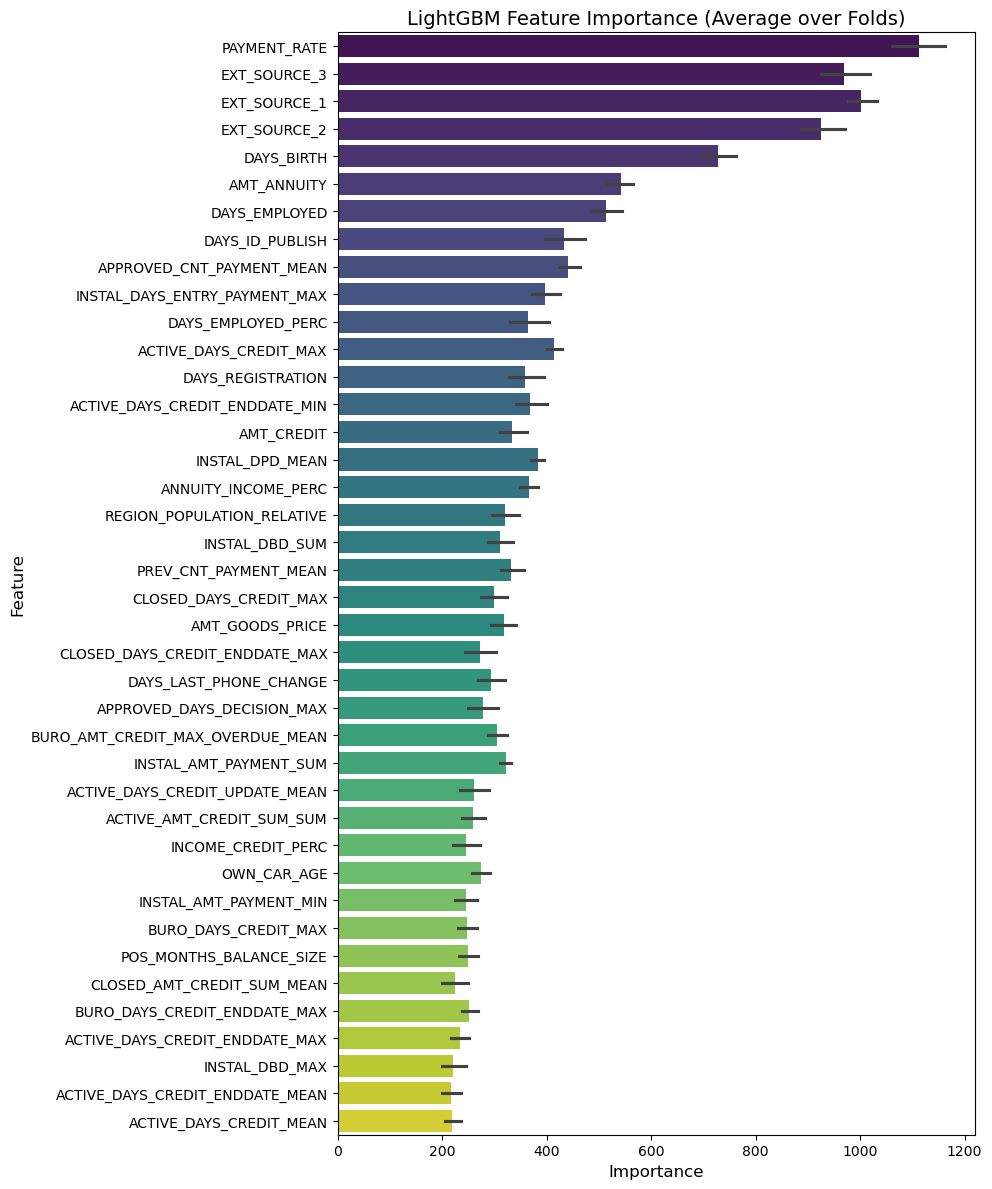

Generating feature importance - done in 1s


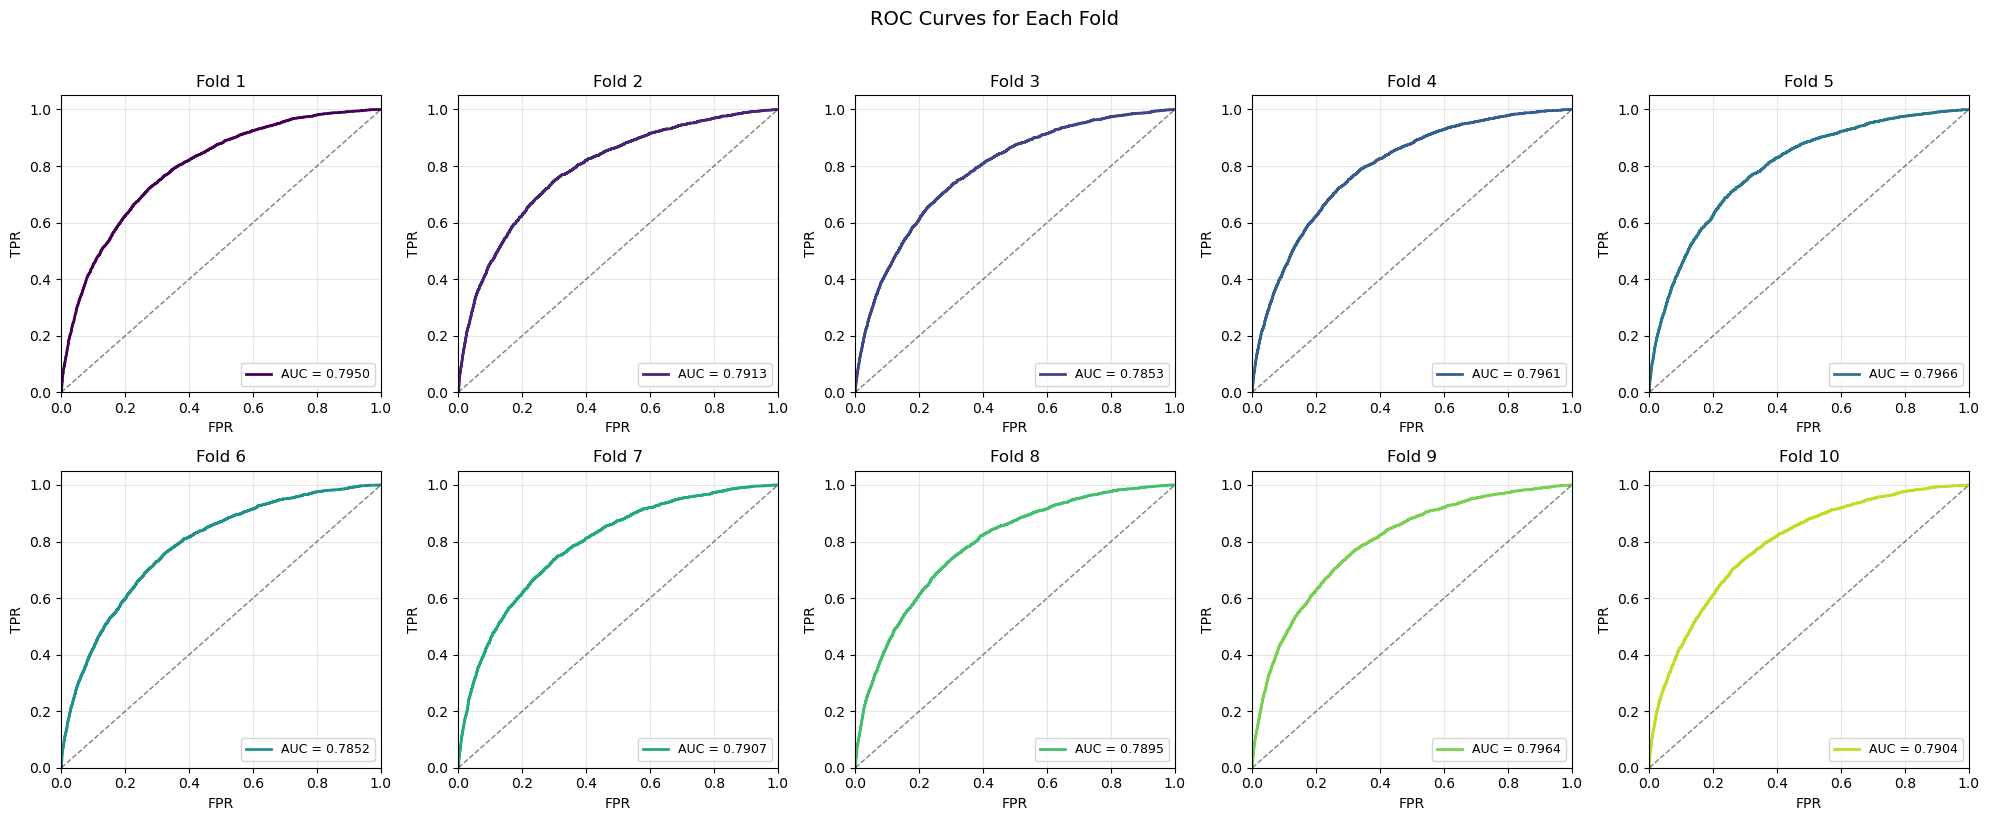

Generating per-fold ROC curves - done in 1s


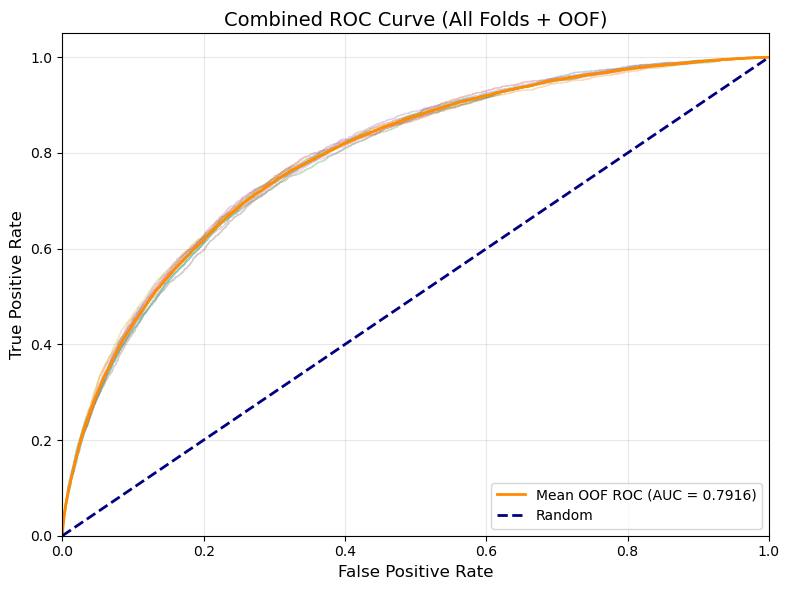

Generating combined ROC curve - done in 0s


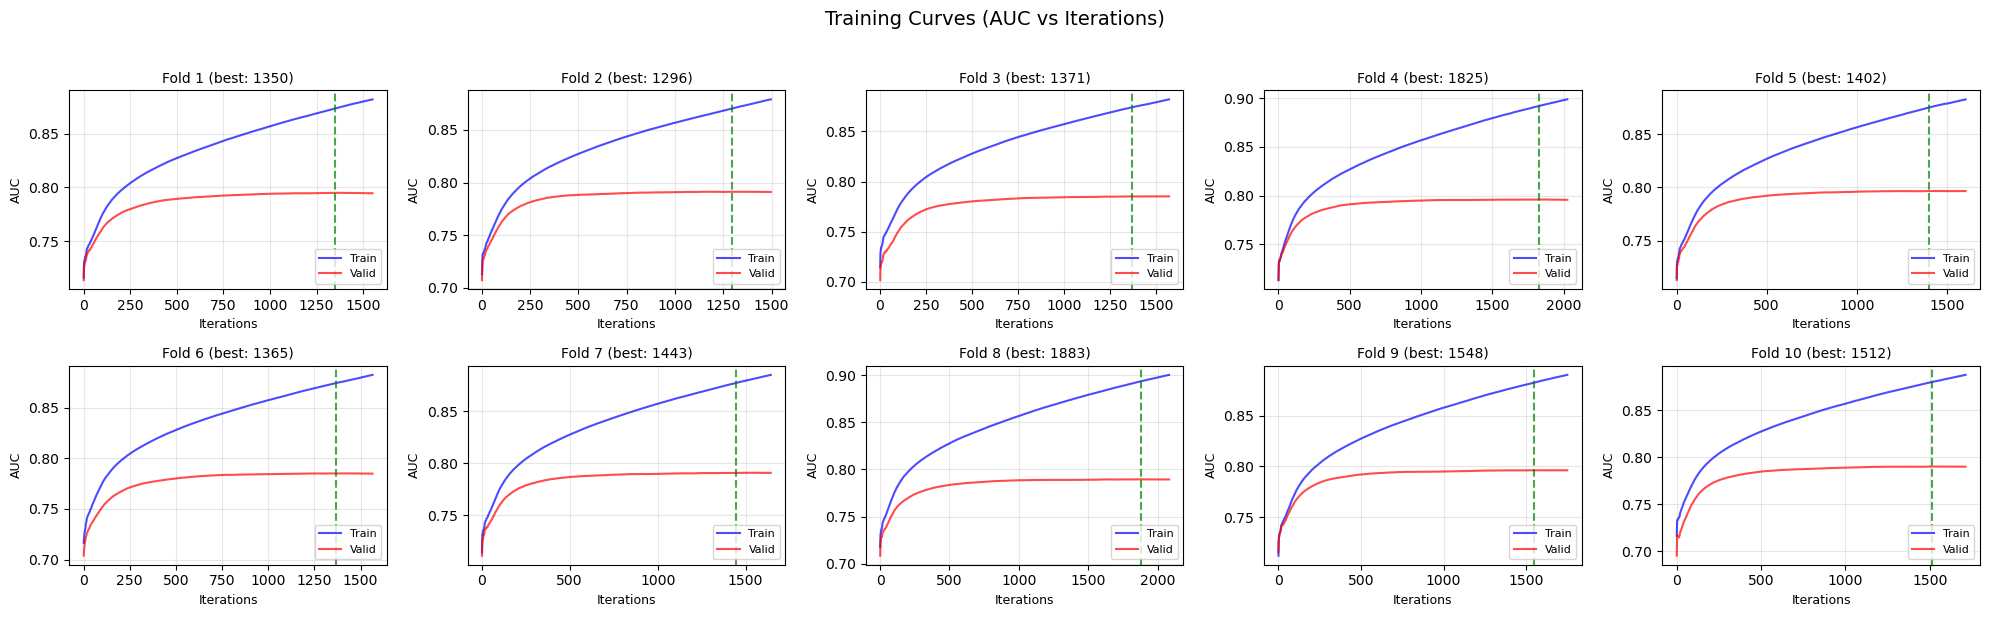

Generating training curves - done in 1s

TRAINING SUMMARY
Number of folds: 10
Features used: 755

Per-Fold AUC:
  Fold  1: 0.795044
  Fold  2: 0.791310
  Fold  3: 0.785260
  Fold  4: 0.796099
  Fold  5: 0.796631
  Fold  6: 0.785199
  Fold  7: 0.790664
  Fold  8: 0.789533
  Fold  9: 0.796374
  Fold 10: 0.790390

Mean Fold AUC: 0.791650
OOF AUC:       0.791629

Output files:
  - submission_kernel02.csv
  - lgbm_importances01.png
  - roc_curves_per_fold.png
  - roc_curve.png
  - training_curves.png


In [5]:
# =============================================================================
# Stage 5: Output & Visualization
# =============================================================================

# --- 1. Feature Importance ---
def display_importances(feature_importance_df):
    cols = (feature_importance_df[["feature", "importance"]]
            .groupby("feature").mean()
            .sort_values(by="importance", ascending=False)[:40].index)
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    plt.figure(figsize=(10, 12))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False), palette="viridis")
    plt.title('LightGBM Feature Importance (Average over Folds)', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png', dpi=150)
    plt.show()
    return cols

# --- 2. Per-Fold ROC Curves ---
def plot_per_fold_roc_curves(fold_results):
    """Plot individual ROC curve for each fold."""
    n_folds = len(fold_results)
    cols = min(5, n_folds)  # 5 columns max
    rows = (n_folds + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if n_folds > 1 else [axes]
    
    colors = plt.cm.viridis(np.linspace(0, 0.9, n_folds))
    
    for idx, fold_data in enumerate(fold_results):
        ax = axes[idx]
        fpr, tpr, _ = roc_curve(fold_data['y_true'], fold_data['y_pred'])
        auc = fold_data['auc']
        
        ax.plot(fpr, tpr, color=colors[idx], lw=2, label=f'AUC = {auc:.4f}')
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
        ax.set_xlabel('FPR', fontsize=10)
        ax.set_ylabel('TPR', fontsize=10)
        ax.set_title(f'Fold {fold_data["fold"]}', fontsize=12)
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_folds, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('ROC Curves for Each Fold', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('roc_curves_per_fold.png', dpi=150, bbox_inches='tight')
    plt.show()

# --- 3. Combined ROC Curve ---
def plot_combined_roc_curve(y_true, y_pred, fold_results):
    """Plot combined OOF ROC curve with all folds overlay."""
    plt.figure(figsize=(8, 6))
    
    # Plot each fold in light color
    for fold_data in fold_results:
        fpr, tpr, _ = roc_curve(fold_data['y_true'], fold_data['y_pred'])
        plt.plot(fpr, tpr, alpha=0.3, lw=1)
    
    # Plot combined OOF
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Mean OOF ROC (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'navy', lw=2, linestyle='--', label='Random')
    
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Combined ROC Curve (All Folds + OOF)', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curve.png', dpi=150)
    plt.show()
    return auc_score

# --- 4. Training Curves ---
def plot_training_curves(training_history):
    n_folds = len(training_history)
    cols = min(5, n_folds)
    rows = (n_folds + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten() if n_folds > 1 else [axes]
    
    for idx, fold_history in enumerate(training_history):
        ax = axes[idx]
        iterations = range(1, len(fold_history['train_auc']) + 1)
        ax.plot(iterations, fold_history['train_auc'], label='Train', color='blue', alpha=0.7)
        ax.plot(iterations, fold_history['valid_auc'], label='Valid', color='red', alpha=0.7)
        ax.axvline(x=fold_history['best_iteration'], color='green', linestyle='--', alpha=0.7)
        ax.set_xlabel('Iterations', fontsize=9)
        ax.set_ylabel('AUC', fontsize=9)
        ax.set_title(f'Fold {fold_history["fold"]} (best: {fold_history["best_iteration"]})', fontsize=10)
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(alpha=0.3)
    
    for idx in range(n_folds, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Training Curves (AUC vs Iterations)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

# === Execute Visualizations ===

with timer("Saving submission file"):
    submission_df.to_csv(SUBMISSION_FILE, index=False)
    print(f"Submission saved to: {SUBMISSION_FILE}")
    print(f"Submission shape: {submission_df.shape}")

with timer("Generating feature importance"):
    top_features = display_importances(feature_importance_df)

with timer("Generating per-fold ROC curves"):
    plot_per_fold_roc_curves(fold_results)

with timer("Generating combined ROC curve"):
    oof_auc = plot_combined_roc_curve(train_targets, oof_preds, fold_results)

with timer("Generating training curves"):
    plot_training_curves(training_history)

# Summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Number of folds: {len(fold_results)}")
print(f"Features used: {len(feature_importance_df['feature'].unique())}")
print(f"\nPer-Fold AUC:")
for fr in fold_results:
    print(f"  Fold {fr['fold']:2d}: {fr['auc']:.6f}")
print(f"\nMean Fold AUC: {np.mean([fr['auc'] for fr in fold_results]):.6f}")
print(f"OOF AUC:       {oof_auc:.6f}")
print(f"\nOutput files:")
print(f"  - {SUBMISSION_FILE}")
print(f"  - lgbm_importances01.png")
print(f"  - roc_curves_per_fold.png")
print(f"  - roc_curve.png")
print(f"  - training_curves.png")